In [1]:
!pip install pandas rdflib networkx
import pandas as pd
from rdflib import Graph, Literal, Namespace, RDF, URIRef
import gzip
import os

In [2]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Building the ttl file into a compressed version first for efficiency and speed purposes**

In [ ]:
import pandas as pd
import gzip
from tqdm import tqdm

#  File paths
input_csv_path = "/content/drive/My Drive/TrafficCount.csv"
output_ttl_path = "/content/drive/My Drive/traffic_graph.ttl.gz"

# CSV columns: RequestID, Boro, Yr, M, D, HH, MM, Vol, SegmentID, WktGeom, street, fromSt, toSt, Direction
# We only need: street, WktGeom, Yr, M, D, HH, MM, Vol
columns_to_keep = ['street', 'WktGeom', 'Yr', 'M', 'D', 'HH', 'MM', 'Vol']

# Set a chunksize -adjusted based on available memory
chunksize = 200000

# This dictionary maps the original street name to a tuple (safe_street, wkt)
street_data = {}

print("Collecting unique streets...")
# Process CSV in chunks to collect all unique street definitions
for chunk in tqdm(pd.read_csv(input_csv_path, usecols=columns_to_keep, chunksize=chunksize),
                  desc="Unique Streets", unit="chunk"):
    # Drop rows missing street or WktGeom
    chunk = chunk.dropna(subset=['street', 'WktGeom'])
    # Normalize street names (strip spaces)
    chunk['street'] = chunk['street'].str.strip()
    for street, wkt in zip(chunk['street'], chunk['WktGeom']):
        if street not in street_data:
            # Create a safe URI component (replace spaces and slashes)
            safe_street = street.replace(" ", "_").replace("/", "_")
            street_data[street] = (safe_street, wkt)

print(f"Collected {len(street_data)} unique streets.")

# --- Open output gzipped Turtle file for writing ---
with gzip.open(output_ttl_path, "wt", encoding="utf-8") as outfile:
    # Write prefix declarations (only once)
    prefix_lines = (
        "@prefix ex: <http://example.org/traffic/> .\n"
        "@prefix geo: <http://www.opengis.net/ont/geosparql#> .\n"
        "@prefix time: <http://www.w3.org/2006/time#> .\n"
        "@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .\n\n"
    )
    outfile.write(prefix_lines)

    # --- Write unique street definitions ---
    for street, (safe_street, wkt) in street_data.items():
        street_def = (
            f"ex:street_{safe_street} a ex:Street ;\n"
            f"    ex:streetName \"{street}\" ;\n"
            f"    geo:asWKT \"{wkt}\"^^geo:wktLiteral .\n\n"
        )
        outfile.write(street_def)

    # --- Pass 2: Process observations in chunks ---
    observation_counter = 1
    print("Processing observations in chunks...")

    # Outer progress bar: over CSV chunks
    for chunk in tqdm(pd.read_csv(input_csv_path, usecols=columns_to_keep, chunksize=chunksize),
                      desc="Observations", unit="chunk"):
        # Drop rows missing required observation fields
        chunk = chunk.dropna(subset=['street', 'Yr', 'M', 'D', 'Vol'])
        # Normalize street names
        chunk['street'] = chunk['street'].str.strip()

        # List to accumulate Turtle lines for this chunk
        observation_lines = []
        # Inner progress bar: over rows in this chunk
        for row in tqdm(chunk.itertuples(index=False), total=len(chunk), leave=False, desc="Rows"):
            street = row.street
            # Ensure the street exists in our precomputed dictionary
            if street not in street_data:
                continue
            safe_street, _ = street_data[street]

            try:
                yr = int(row.Yr)
                m = int(row.M)
                d = int(row.D)
                vol = int(row.Vol)
            except Exception:
                continue  # Skip rows with conversion issues

            # HH and MM are optional
            hh = f"    time:hour {int(row.HH)} ;\n" if pd.notnull(row.HH) else ""
            mm = f"    time:minute {int(row.MM)} ;\n" if pd.notnull(row.MM) else ""

            observation = (
                f"ex:trafficObservation_{observation_counter} a ex:TrafficObservation ;\n"
                f"    ex:observedAt ex:street_{safe_street} ;\n"
                f"    time:year {yr} ;\n"
                f"    time:month {m} ;\n"
                f"    time:day {d} ;\n"
                f"{hh}"
                f"{mm}"
                f"    ex:trafficVolume {vol} .\n\n"
            )
            observation_lines.append(observation)
            observation_counter += 1

        # Write this chunk's observations to the output file
        outfile.write("".join(observation_lines))

print(f"\nConversion Completed! Turtle file saved at: {output_ttl_path}")

Unique Streets: 9chunk [00:03,  2.43chunk/s]


Collected 2328 unique streets.
Processing observations in chunks...


Observations: 0chunk [00:00, ?chunk/s]
Rows:  97%|█████████▋| 193358/200000 [00:00<00:00, 198254.71it/s]
Observations: 1chunk [00:02,  2.90s/chunk]
Rows:  96%|█████████▌| 191061/200000 [00:00<00:00, 195492.08it/s]
Observations: 2chunk [00:05,  2.93s/chunk]
Rows:  95%|█████████▍| 189480/200000 [00:01<00:00, 109752.96it/s]
Observations: 3chunk [00:10,  3.55s/chunk]
Rows:  91%|█████████▏| 182808/200000 [00:00<00:00, 194547.57it/s]
Observations: 4chunk [00:13,  3.31s/chunk]
Rows:  95%|█████████▍| 189708/200000 [00:00<00:00, 200432.50it/s]
Observations: 5chunk [00:16,  3.18s/chunk]
Rows:  90%|████████▉ | 179911/200000 [00:00<00:00, 185173.51it/s]
Observations: 6chunk [00:19,  3.11s/chunk]
Rows:  95%|█████████▍| 189563/200000 [00:01<00:00, 121172.21it/s]
Observations: 7chunk [00:22,  3.30s/chunk]
Rows:  95%|█████████▌| 190205/200000 [00:01<00:00, 192365.94it/s]
Observations: 8chunk [00:26,  3.34s/chunk]
Rows:  94%|█████████▍| 105651/112605 [00:00<00:00, 108218.33it/s]
Observations: 9chunk [0


Conversion Completed! Turtle file saved at: /content/drive/My Drive/traffic_graph.ttl.gz


# **Try converting to N-triples instead**

In [10]:
import pandas as pd
from tqdm import tqdm

# File paths
input_csv_path = "/content/drive/My Drive/TrafficCount.csv"
output_nt_path = "/content/drive/My Drive/traffic_graph.nt"


# CSV columns: RequestID, Boro, Yr, M, D, HH, MM, Vol, SegmentID, WktGeom, street, fromSt, toSt, Direction
# We only need the following columns:
columns_to_keep = ['street', 'WktGeom', 'Yr', 'M', 'D', 'HH', 'MM', 'Vol']

# Set chunk size
chunksize = 200000

# This dictionary maps the street name to a tuple: (safe_street, WktGeom)
# "safe_street" is used to create a valid URI (spaces and "/" are replaced by underscores)
street_data = {}

print("Collecting unique streets...")
csv_iter = pd.read_csv(input_csv_path, usecols=columns_to_keep, chunksize=chunksize)
for chunk in tqdm(csv_iter, desc="Unique Streets", unit="chunk"):
    # Drop rows missing required street or WktGeom values
    chunk = chunk.dropna(subset=['street', 'WktGeom'])
    # Remove extraneous spaces from street names
    chunk['street'] = chunk['street'].str.strip()
    for street, wkt in zip(chunk['street'], chunk['WktGeom']):
        if street not in street_data:
            safe_street = street.replace(" ", "_").replace("/", "_")
            street_data[street] = (safe_street, str(wkt))

print(f"Collected {len(street_data)} unique streets.")

# Open output file to write N‑Triples
with open(output_nt_path, "wt", encoding="utf-8") as outfile:

    #  Write unique street triples
    # For each street, we write three triples:
    # 1. Its rdf:type as ex:Street
    # 2. Its ex:streetName literal
    # 3. Its geo:asWKT literal with datatype geo:wktLiteral
    for street, (safe_street, wkt) in street_data.items():
        subject = f"<http://example.org/traffic/street_{safe_street}>"
        # Triple for rdf:type
        outfile.write(f"{subject} <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://example.org/traffic/Street> .\n")
        # Triple for streetName
        outfile.write(f'{subject} <http://example.org/traffic/streetName> "{street}" .\n')
        # Triple for geo:asWKT (using the geo:wktLiteral datatype)
        outfile.write(f'{subject} <http://www.opengis.net/ont/geosparql#asWKT> "{wkt}"^^<http://www.opengis.net/ont/geosparql#wktLiteral> .\n')

    # Process traffic observations
    observation_counter = 1  # Used to create unique observation URIs
    print("Processing observations...")
    csv_iter = pd.read_csv(input_csv_path, usecols=columns_to_keep, chunksize=chunksize)
    for chunk in tqdm(csv_iter, desc="Observations", unit="chunk"):
        # Drop rows missing any required observation fields
        chunk = chunk.dropna(subset=['street', 'Yr', 'M', 'D', 'Vol'])
        chunk['street'] = chunk['street'].str.strip()

        for row in chunk.itertuples(index=False):
            street = row.street
            if street not in street_data:
                continue  # Skip observations with no corresponding street
            safe_street = street_data[street][0]
            obs_uri = f"<http://example.org/traffic/trafficObservation_{observation_counter}>"
            observation_counter += 1

            # Write triple: Observation rdf:type TrafficObservation
            outfile.write(f"{obs_uri} <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://example.org/traffic/TrafficObservation> .\n")
            # Write triple: observedAt (linking to the street)
            outfile.write(f"{obs_uri} <http://example.org/traffic/observedAt> <http://example.org/traffic/street_{safe_street}> .\n")

            try:
                year = int(row.Yr)
                month = int(row.M)
                day = int(row.D)
                volume = int(row.Vol)
            except Exception:
                continue  # Skip this row if conversion fails

            # Write time properties
            outfile.write(f'{obs_uri} <http://www.w3.org/2006/time#year> "{year}" .\n')
            outfile.write(f'{obs_uri} <http://www.w3.org/2006/time#month> "{month}" .\n')
            outfile.write(f'{obs_uri} <http://www.w3.org/2006/time#day> "{day}" .\n')


            if pd.notnull(row.HH):
                try:
                    hh = int(row.HH)
                    outfile.write(f'{obs_uri} <http://www.w3.org/2006/time#hour> "{hh}" .\n')
                except Exception:
                    pass
            if pd.notnull(row.MM):
                try:
                    mm = int(row.MM)
                    outfile.write(f'{obs_uri} <http://www.w3.org/2006/time#minute> "{mm}" .\n')
                except Exception:
                    pass

            # Write traffic volume property
            outfile.write(f'{obs_uri} <http://example.org/traffic/trafficVolume> "{volume}" .\n')

print("Conversion complete!")
print(f"N-Triples file saved at: {output_nt_path}")


Unique Streets: 9chunk [00:05,  1.60chunk/s]


Collected 2328 unique streets.
Processing observations...


Observations: 9chunk [00:31,  3.53s/chunk]

Conversion complete!
N-Triples file saved at: /content/drive/My Drive/traffic_graph.nt


# **Check a sample of the graph for testing purposes**

In [5]:
import rdflib

ttl_file = "/content/drive/My Drive/traffic_graph.ttl"

rdf_graph = rdflib.Graph()

try:
    rdf_graph.parse(ttl_file, format="turtle")
    print("TTL file loaded successfully!")
except Exception as e:
    print("Error loading TTL file:", e)


Error loading TTL file: at line 22 of <>:
Bad syntax (expected '.' or '}' or ']' at end of statement) at ^ in:
"...b'17590.22210737958)"^^geo:wktLiteral .\n\nex:street_S_B_12_AVE_'^b'@_70_ST a ex:Street ;\n    ex:streetName "S/B 12 AVE @ 70 ST"'..."


# **Try to parse and convert to NetworkX graph first**

In [1]:
import rdflib
from rdflib.plugins.parsers.ntriples import W3CNTriplesParser
import networkx as nx
from tqdm import tqdm

def canonicalize_uri(uri_str):
    """
    For street IRIs (assumed to start with "http://example.org/traffic/street_"),
    replace spaces with underscores.
    """
    prefix = "http://example.org/traffic/street_"
    if uri_str.startswith(prefix):
        rest = uri_str[len(prefix):].replace(" ", "_")
        return prefix + rest
    return uri_str

class NTTripleSink:
    def __init__(self, nx_graph, pbar=None):
        self.nx_graph = nx_graph
        self.pbar = pbar

    def triple(self, s, p, o):
        s_str = canonicalize_uri(str(s))
        p_str = str(p)

        # Handle rdf:type triples: store as a node attribute.
        if p == rdflib.RDF.type:
            if s_str not in self.nx_graph:
                self.nx_graph.add_node(s_str)
            self.nx_graph.nodes[s_str]["type"] = str(o)
        else:
            # If the object is a literal, add it as a property to the subject node
            if isinstance(o, rdflib.term.Literal):
                if s_str not in self.nx_graph:
                    self.nx_graph.add_node(s_str)
                self.nx_graph.nodes[s_str][p_str] = str(o)
            else:
                # For non literal objects, add an edge from subject to object
                o_str = canonicalize_uri(str(o))
                if s_str not in self.nx_graph:
                    self.nx_graph.add_node(s_str)
                if o_str not in self.nx_graph:
                    self.nx_graph.add_node(o_str)
                self.nx_graph.add_edge(s_str, o_str, predicate=p_str)

        if self.pbar:
            self.pbar.update(1)


nt_file = "/content/drive/My Drive/traffic_graph.nt"

# Create an empty NetworkX MultiDiGraph.
G = nx.MultiDiGraph()

# Count total number of lines (triples) in the N‑Triples file for progress tracking
print("Counting total lines in the N‑Triples file...")
with open(nt_file, "r", encoding="utf-8") as f:
    total_lines = sum(1 for _ in f)
print(f"Total triples (lines): {total_lines}")

# Set up a progress bar
pbar = tqdm(total=total_lines, desc="Processing NT triples", unit="triple")

# Create our custom sink
sink = NTTripleSink(G, pbar)

# Create the parser using W3CNTriplesParser (which acts like NTriplesParser)
parser = W3CNTriplesParser(sink)

# Stream-parse the N‑Triples file
print("Streaming and processing N‑Triples...")
with open(nt_file, "r", encoding="utf-8") as f:
    parser.parse(f)

pbar.close()

print("Conversion complete!")
print(f"NetworkX graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")


Counting total lines in the N‑Triples file...
Total triples (lines): 13707824


Processing NT triples:   0%|          | 0/13707824 [00:00<?, ?triple/s]

Streaming and processing N‑Triples...


Processing NT triples: 100%|██████████| 13707824/13707824 [06:02<00:00, 37773.89triple/s]


Conversion complete!
NetworkX graph has 1714933 nodes and 1712605 edges.


# Parse datetime from Nx Graph.
# Extracting all observations linked to each street and putting them into a timeseries dataframe.

Total street nodes in graph: 2328
Building observedAt index...


Indexing observedAt edges: 100%|██████████| 1712605/1712605 [00:02<00:00, 636078.49edge/s]


Index built for 2328 streets with observations.

Street: http://example.org/traffic/street_SLOSSON_AVE_NB_APPROACH_TO_WINDSOR_RD
Number of observations: 852
             datetime  volume
0 2011-03-05 12:00:00    83.0
1 2011-03-05 12:15:00   158.0
2 2011-03-05 12:30:00   156.0
3 2011-03-05 12:45:00   150.0
4 2011-03-05 13:00:00   153.0


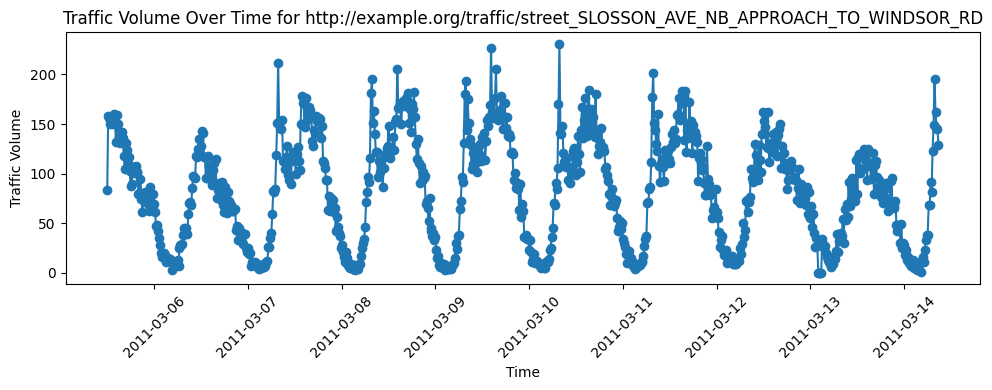


Street: http://example.org/traffic/street_USS_IOWA_CIRCLE
Number of observations: 159
             datetime  volume
0 2019-04-19 08:15:00   202.0
1 2019-04-19 08:30:00   206.0
2 2019-04-19 08:45:00   188.0
3 2019-04-19 09:00:00   212.0
4 2019-04-19 09:15:00   218.0


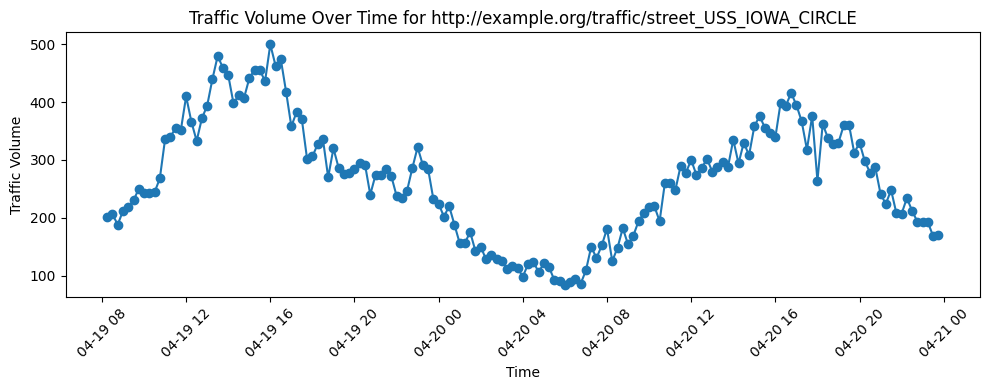


Street: http://example.org/traffic/street_N_B_FT_HAMILTON_PKWY_@_60_ST
Number of observations: 1
             datetime  volume
0 2009-05-30 07:30:00    94.0


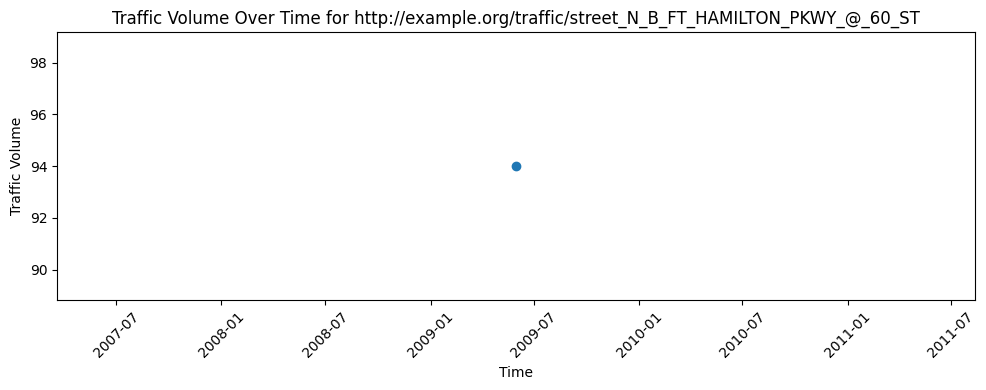


Street: http://example.org/traffic/street_TER_DR
Number of observations: 1254
             datetime  volume
0 2013-06-29 09:00:00     3.0
1 2013-07-16 07:15:00     0.0
2 2013-07-16 07:30:00     5.0
3 2013-07-20 08:15:00     6.0
4 2013-07-20 08:30:00     4.0


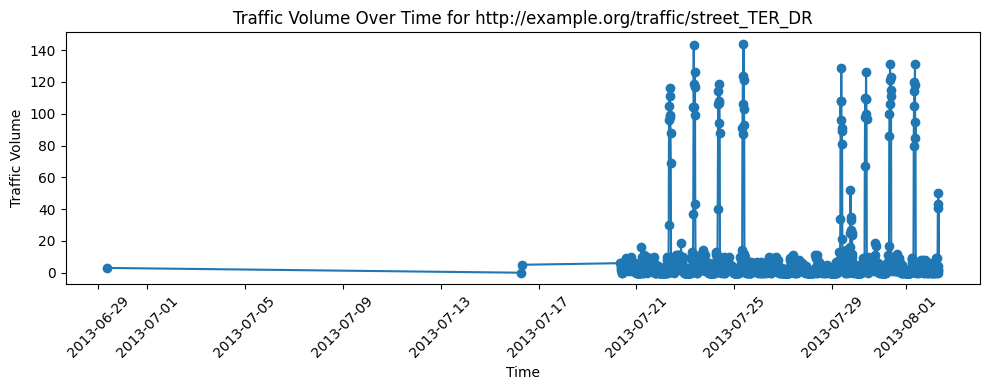


Street: http://example.org/traffic/street_GIVAN_AVENUE
Number of observations: 322
             datetime  volume
0 2017-12-12 00:00:00     0.0
1 2017-12-12 00:15:00     4.0
2 2017-12-12 00:30:00     6.0
3 2017-12-12 00:45:00     3.0
4 2017-12-12 01:00:00     2.0


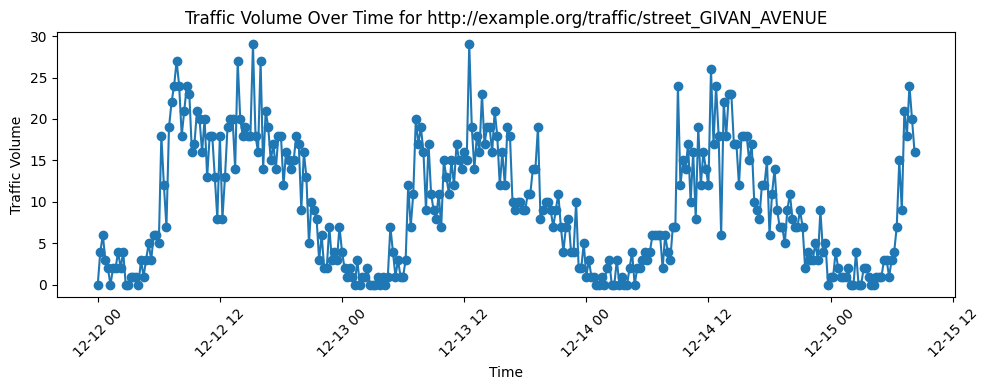

In [10]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm

# Define expected IRIs for node types and predicates
street_type_iri = "http://example.org/traffic/Street"
traffic_obs_type_iri = "http://example.org/traffic/TrafficObservation"
observed_at_predicate = "http://example.org/traffic/observedAt"
time_year = "http://www.w3.org/2006/time#year"
time_month = "http://www.w3.org/2006/time#month"
time_day = "http://www.w3.org/2006/time#day"
time_hour = "http://www.w3.org/2006/time#hour"
time_minute = "http://www.w3.org/2006/time#minute"
traffic_volume_predicate = "http://example.org/traffic/trafficVolume"

def parse_datetime_from_node(node_data):
    """
    Given a dictionary of node attributes from the NetworkX graph,
    extract time properties and return a datetime object.
    Hour and minute are optional
    """
    try:
        year = int(node_data.get(time_year))
        month = int(node_data.get(time_month, 1))
        day = int(node_data.get(time_day, 1))
        hour = int(node_data.get(time_hour, 0))
        minute = int(node_data.get(time_minute, 0))
        return datetime.datetime(year, month, day, hour, minute)
    except Exception:
        return None

def build_observed_index(G):
    """
    Build an index (a dictionary) that maps each street node (target of an observedAt edge)
    to a list of observation nodes (source of the edge)
    Uses a progress bar to track processing of edges
    """
    observed_index = {}
    for u, v, data in tqdm(G.edges(data=True), total=G.number_of_edges(),
                             desc="Indexing observedAt edges", unit="edge"):
        if data.get("predicate") == observed_at_predicate:
            # v is the street node
            # u is the observation node
            observed_index.setdefault(v, []).append(u)
    return observed_index

def extract_time_series_from_index(G, street_node, observed_index):
    """
    Given a street node and the observed_index, extract all observation nodes that point
    to this street and build a time series DataFrame.
    Returns a pandas DataFrame with columns: datetime and volume.
    """
    observations = []
    if street_node not in observed_index:
        return pd.DataFrame(columns=["datetime", "volume"])
    for obs in observed_index[street_node]:
        node_data = G.nodes[obs]
        dt = parse_datetime_from_node(node_data)
        try:
            volume = float(node_data.get(traffic_volume_predicate, np.nan))
        except Exception:
            continue
        if dt is not None and not np.isnan(volume):
            observations.append((dt, volume))
    if not observations:
        return pd.DataFrame(columns=["datetime", "volume"])
    # Sort observations by datetime
    observations.sort(key=lambda x: x[0])
    return pd.DataFrame(observations, columns=["datetime", "volume"])


# G is the NetworkX graph built from the N‑Triples file aka traffic_graph.nt
# G was built in previous code block using the streaming parser

# Filter out street nodes based on their type attribute
street_nodes = [node for node, data in G.nodes(data=True) if data.get("type") == street_type_iri]
print(f"Total street nodes in graph: {len(street_nodes)}")

# Build an index mapping each street node to its observation nodes
print("Building observedAt index...")
observed_index = build_observed_index(G)
print(f"Index built for {len(observed_index)} streets with observations.")

# Sample a few streets for analysis (e.g., 5 streets)
if len(street_nodes) < 5:
    sample_streets = street_nodes
else:
    sample_streets = random.sample(street_nodes, 5)

# For each sampled street, extract the time series and visualize it
for street in sample_streets:
    ts_df = extract_time_series_from_index(G, street, observed_index)
    print(f"\nStreet: {street}")
    print(f"Number of observations: {len(ts_df)}")
    if not ts_df.empty:
        print(ts_df.head())
        plt.figure(figsize=(10, 4))
        plt.plot(ts_df["datetime"], ts_df["volume"], marker="o")
        plt.title(f"Traffic Volume Over Time for {street}")
        plt.xlabel("Time")
        plt.ylabel("Traffic Volume")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("No valid observations found for this street.")


In [8]:
ts_df.head()

,datetime,volume
0,2012-07-04 04:45:00,91.0
1,2013-02-22 10:45:00,103.0
2,2013-02-22 11:00:00,142.0
3,2013-02-22 11:15:00,154.0
4,2013-02-22 11:30:00,117.0


# **Manually copy and paste street IRI from traffic_graph.nt file.**
# **Run this block to get a Traffic Volume Over Time plot for a street**

Number of observations: 1233
             datetime  volume
0 2010-03-10 12:30:00     4.0
1 2010-03-10 12:45:00    69.0
2 2010-03-10 13:00:00   126.0
3 2010-03-10 13:15:00   142.0
4 2010-03-10 13:30:00   120.0


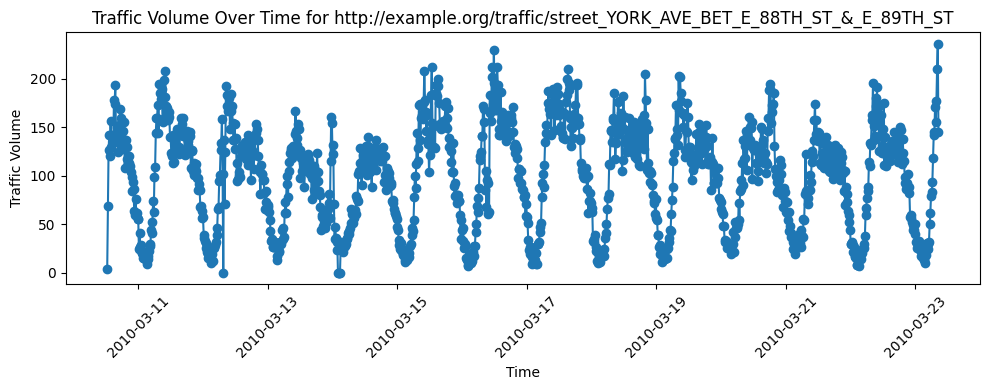

In [13]:
import matplotlib.pyplot as plt

# Replace this with the exact IRI from the .nt file (without the angle brackets).
street_iri = "http://example.org/traffic/street_YORK_AVE_BET_E_88TH_ST_&_E_89TH_ST"

# Extract the time series for this street.
ts_df1 = extract_time_series_from_index(G, street_iri, observed_index)

# Check if we have any observations.
if ts_df1.empty:
    print(f"No valid observations found for street: {street_iri}")
else:
    print(f"Number of observations: {len(ts_df1)}")
    print(ts_df1.head())  # Display first few rows for inspection

    # Plot the time series
    plt.figure(figsize=(10, 4))
    plt.plot(ts_df1["datetime"], ts_df1["volume"], marker="o")
    plt.title(f"Traffic Volume Over Time for {street_iri}")
    plt.xlabel("Time")
    plt.ylabel("Traffic Volume")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# **If (not satisfied with plot) then read comments and run this block**

In [6]:

import matplotlib.pyplot as plt
# If plot is not so readable  and has too many observations, you can "zoom" in a year
# by running this block to get a more "clear" inspection and view (that is of course if we have observations tha span across multiple years)

# Choose the year we want to  inspect (e.g. 2022)
year_to_inspect = 2022

# Filter the Timeseries DataFrame for only that year
filtered_df = ts_df1[ts_df1["datetime"].dt.year == year_to_inspect]

# Check if there's  any data  for that year first
if filtered_df.empty:
    print(f"No observations found for the year {year_to_inspect}.")
else:
    # Plot the filtered data
    plt.figure(figsize=(10, 4))
    plt.plot(filtered_df["datetime"], filtered_df["volume"], marker="o")
    plt.title(f"Traffic Volume Over Time (Year = {year_to_inspect})")
    plt.xlabel("Time")
    plt.ylabel("Traffic Volume")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


No observations found for the year 2011.


In [9]:
print(ts_df.columns)


Index(['datetime', 'volume'], dtype='object')


# **Pick a particular street to Interpolate missing values**

In [35]:
# Build a dictionary mapping each street IRI to its time series DataFrame (e.g. http://example.org/traffic/street_THOMSON_ST_BET_33TH_DR_&_QUEENSBORO_BRIDGE_RAMP)
street_ts_dict = {
    street: extract_time_series_from_index(G, street, observed_index)
    for street in street_nodes
}
selected_street = "http://example.org/traffic/street_THOMSON_ST_BET_33TH_DR_&_QUEENSBORO_BRIDGE_RAMP"

# **Missing observations (links) through time-based Interpolation for a particular street (Statistical Method)**

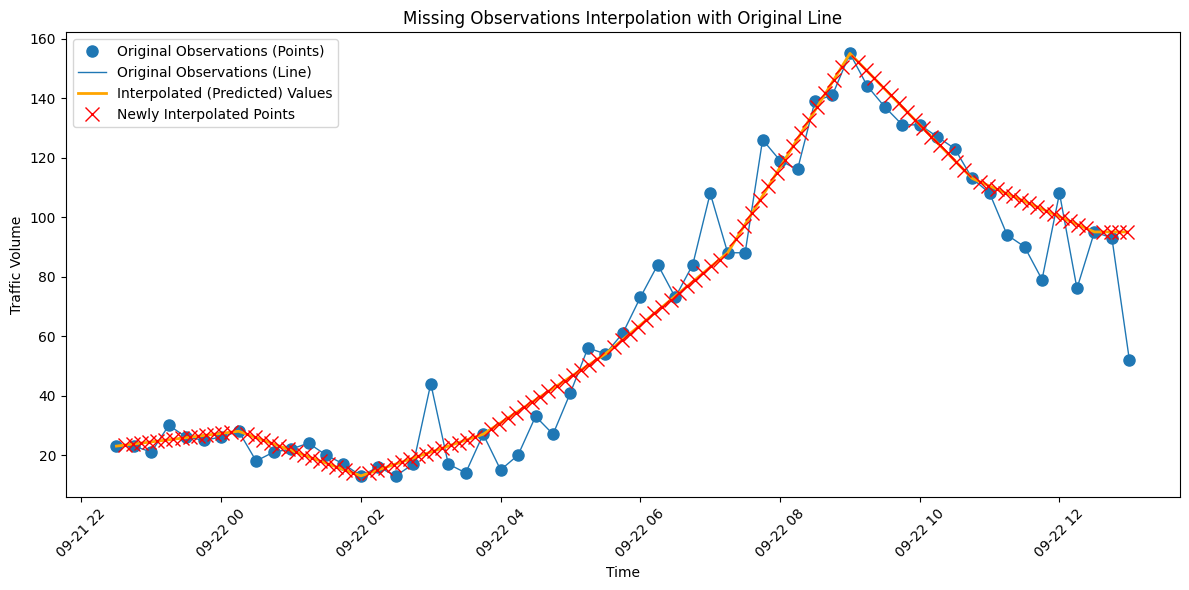

In [43]:
# Get a copy of the time series DataFrame for the street we selected above
ts_df_specific = street_ts_dict[selected_street].copy()

# Interpolation on this single-street DataFrame
# Ensure the datetime column is in datetime format
ts_df_specific["datetime"] = pd.to_datetime(ts_df_specific["datetime"])

# Sort by datetime and set as index
ts_df_specific = ts_df_specific.sort_values("datetime").set_index("datetime")

# Define the desired frequency for the time series (e.g., every 15 minutes)
desired_freq = "7min"

# Create a full datetime range from the minimum to maximum observation time.
full_range = pd.date_range(start=ts_df_specific.index.min(),
                           end=ts_df_specific.index.max(),
                           freq=desired_freq)

# Reindex the DataFrame to include all time slots (introducing NaNs for missing time steps).
ts_reindexed = ts_df_specific.reindex(full_range)

# Interpolate missing values using time-based linear interpolation.
ts_interpolated = ts_reindexed.interpolate(method='time')

# Optionally, highlight newly interpolated points:
new_points = ts_interpolated.index.difference(ts_df_specific.index)

# Plot the original and interpolated time series.
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

# Original observations
plt.plot(
    ts_df_specific.index,
    ts_df_specific["volume"],
    'o',
    color='C0',
    label="Original Observations (Points)",
    markersize=8
)

# Original observations line
plt.plot(
    ts_df_specific.index,
    ts_df_specific["volume"],
    '-',
    color='C0',
    linewidth=1,
    label="Original Observations (Line)"
)

# Interpolated line
plt.plot(
    ts_interpolated.index,
    ts_interpolated["volume"],
    '-',
    color='orange',
    linewidth=2,
    label="Interpolated (Predicted) Values"
)

# Newly interpolated points in red 'x'
if len(new_points) > 0:
    plt.plot(
        new_points,
        ts_interpolated.loc[new_points, "volume"],
        'x',
        color='red',
        markersize=10,
        label="Newly Interpolated Points"
    )

plt.xlabel("Time")
plt.ylabel("Traffic Volume")
plt.title("Missing Observations Interpolation with Original Line")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# **Run this to zoom into a smaller time interval for better inspection of interpolated values**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

"""
matplotlib manually formats the datetime when plotting. If in the plot the year in the format of 20XX is not shown,
that means we're looking into a particular year because the observations for the particular street are from the same year only.
"""

""" DISCLAIMER """
#Not sure if this still works

# Option 1: Define a specific one-hour interval manually.
# Replace the start_time below with the desired datetime.
# For example I want to see what are the missing values for the interval starting from 2014-08-30 12:00:00
start_time = pd.Timestamp("2016-01-01 12:00:00")
end_time = start_time + pd.Timedelta(hours=1)

# Option 2: Alternatively, to zoom in on the first hour of your data, uncomment:
# start_time = ts_df.index.min()
# end_time = start_time + pd.Timedelta(hours=1)

# Filter the DataFrame for the one-hour interval.
zoom_df = ts_df.loc[start_time:end_time]

# Optionally, if you want to reindex to a finer frequency (e.g., 1-minute intervals)
# so that missing points are interpolated:
desired_freq = "1min"  # You can change this to 15min, 5min, etc.
full_range = pd.date_range(start=start_time, end=end_time, freq=desired_freq)
zoom_df = zoom_df.reindex(full_range)
zoom_df = zoom_df.interpolate(method='time')

# Plot the zoomed-in time series.
plt.figure(figsize=(12, 6))
plt.plot(zoom_df.index, zoom_df["volume"], marker="o", linestyle='-')
plt.xlabel("Time")
plt.ylabel("Traffic Volume")
plt.title(f"Traffic Volume from {start_time} to {end_time}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# **Graph Embeddings Approach (Node2Vec)**

In [49]:
!pip install node2vec

# **Installing PecanPy which uses an alternative, more optimized version of Node2Vec that handles better large graphs like the one we are using in this project. It does so by using more efficient data structures and parallel processing.**

In [2]:
!pip install pecanpy

In [9]:
!pip show pecanpy

Name: pecanpy
Version: 2.0.9
Summary: A parallelized, efficient, and accelerated node2vec
Home-page: https://github.com/krishnanlab/PecanPy
Author: Remy Liu
Author-email: liurenmi@msu.edu
License: BSD 3-Clause License
Location: /usr/local/lib/python3.11/dist-packages
Requires: gensim, nptyping, numba, numba-progress, numpy, typing-extensions
Required-by: 


# **Had huge import issues, dropped it altogether but I left the blocks for reference**

# **Trying Node2Vec Again**

# **First, sampling the graph G for feasibility purposes..**

In [14]:
print(f"NetworkX graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

NetworkX graph has 1714933 nodes and 1712605 edges.


In [ ]:
from torch_geometric.nn import Node2Vec
observed_index = build_observed_index(G)
print(f"Index built for {len(observed_index)} streets with observations.")


# Sample 20% of the Nodes from G and Create a Subgraph
all_nodes = list(G.nodes())
sample_size = int(0.05 * len(all_nodes))
sampled_nodes = random.sample(all_nodes, sample_size)
print(f"Sampled {len(sampled_nodes)} nodes out of {len(all_nodes)} from G.")
subG = G.subgraph(sampled_nodes).copy()
print(f"Subgraph has {subG.number_of_nodes()} nodes and {subG.number_of_edges()} edges.")

# Run Node2Vec on the Subgraph Using torch_geometric.nn.Node2Vec


# Create a mapping from node ID to a new index.
nodes = list(subG.nodes())
node2idx = {node: i for i, node in enumerate(nodes)}
edge_list = []
for u, v in subG.edges():
    # Add both directions to make the graph undirected.
    edge_list.append([node2idx[u], node2idx[v]])
    edge_list.append([node2idx[v], node2idx[u]])
import torch
edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
num_nodes = len(nodes)

# Create and train the Node2Vec model.
model = Node2Vec(edge_index, embedding_dim=16, walk_length=10, context_size=5,
                 walks_per_node=50, num_nodes=num_nodes, p=1, q=1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
loader = model.loader(batch_size=128, shuffle=True, num_workers=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train_node2vec():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        pos_rw = pos_rw.to(device)
        neg_rw = neg_rw.to(device)
        loss = model.loss(pos_rw, neg_rw)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

print("Training Node2Vec model...")
for epoch in range(1, 101):
    loss = train_node2vec()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

model.eval()
z = model()  # Final embeddings: tensor of shape [num_nodes, 16]
# Map embeddings back to original node IDs.
embeddings = {nodes[i]: z[i].detach().cpu().numpy() for i in range(num_nodes)}


# Step 3: Select a Street for Forecasting from the Sampled Subgraph
sampled_street_nodes = [node for node in sampled_nodes if G.nodes[node].get("type") == street_type_iri and node in observed_index]
if not sampled_street_nodes:
    raise ValueError("No street nodes with observations in the sampled subgraph.")
selected_street = random.choice(sampled_street_nodes)
print(f"Selected street for forecasting: {selected_street}")


# Extract and Sample Time Series Data for the Selected Street
ts_df_full = extract_time_series_from_index(G, selected_street, observed_index)
print(f"Full time series for street {selected_street} has {len(ts_df_full)} observations.")
# For manageable processing, sample the last 50 observations.
if len(ts_df_full) > 50:
    ts_df_sample = ts_df_full.tail(50).copy()
else:
    ts_df_sample = ts_df_full.copy()
print("Sampled time series DataFrame:")
print(ts_df_sample.head())

# Visualize the sampled time series.
plt.figure(figsize=(10, 4))
plt.plot(ts_df_sample["datetime"], ts_df_sample["volume"], marker="o")
plt.title(f"Traffic Volume for Street {selected_street} (Sampled)")
plt.xlabel("Time")
plt.ylabel("Traffic Volume")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Prepare Data for Forecasting and Train a Linear Regression Model

forecast_horizon = 10  # Predict next 10 observations (each 2 minutes apart)
values = ts_df_sample["volume"].values
if len(values) < forecast_horizon + 1:
    raise ValueError("Not enough observations for the chosen forecast horizon.")

X_list = []
Y_list = []
# Use a sliding window: feature is the observed value at time t concatenated with the street embedding.
# Target is the next 10 observations.
for t in range(len(values) - forecast_horizon):
    # Use the embedding from our torch_geometric Node2Vec model.
    emb = embeddings[selected_street]
    x_feature = np.concatenate(([values[t]], emb))  # shape: (1 + 16,)
    y_target = values[t+1:t+1+forecast_horizon]
    X_list.append(x_feature)
    Y_list.append(y_target)

X = np.array(X_list)
Y = np.array(Y_list)
print("Training feature shape:", X.shape)
print("Training target shape:", Y.shape)

# Split data into training and testing sets (80/20 split).
split_idx = int(0.8 * len(X))
X_train, Y_train = X[:split_idx], Y[:split_idx]
X_test, Y_test = X[split_idx:], Y[split_idx:]

regressor = LinearRegression()
regressor.fit(X_train, Y_train)
Y_pred = regressor.predict(X_test)
mse = mean_squared_error(Y_test, Y_pred)
print("Test MSE:", mse)

# ----------------------------
# Step 6: Predict Future Observations for the Selected Street
# ----------------------------
last_value = values[-1]
feature_vector = np.concatenate(([last_value], embeddings[selected_street])).reshape(1, -1)
future_prediction = regressor.predict(feature_vector)
print(f"Future prediction for street {selected_street} (next {forecast_horizon} observations):")
print(future_prediction.flatten())

Indexing observedAt edges: 100%|██████████| 1712605/1712605 [00:02<00:00, 618039.36edge/s]


Index built for 2328 streets with observations.
Sampled 85746 nodes out of 1714933 from G.
Subgraph has 85746 nodes and 2758 edges.
Training Node2Vec model...
Epoch: 010, Loss: 0.8586
Epoch: 020, Loss: 0.8552
Epoch: 030, Loss: 0.8521
Epoch: 040, Loss: 0.8491
Epoch: 050, Loss: 0.8456
Epoch: 060, Loss: 0.8412
Epoch: 070, Loss: 0.8357
Epoch: 080, Loss: 0.8302


In [1]:
forecast_horizon = future_prediction.shape[1]

# Get the last datetime from the historical data.
last_datetime = ts_df_sample["datetime"].iloc[-1]
# Assuming observations are 2 minutes apart:
time_interval = pd.Timedelta(minutes=2)
forecast_datetimes = [last_datetime + (i+1)*time_interval for i in range(forecast_horizon)]

plt.figure(figsize=(12, 6))
# Plot historical observations.
plt.plot(ts_df_sample["datetime"], ts_df_sample["volume"], marker="o", linestyle="-", label="Historical Observations")
# Plot forecasted future observations in a different color (e.g., red) and marker (e.g., 'x').
plt.plot(forecast_datetimes, future_prediction.flatten(), marker="x", linestyle="--", color="red", label="Forecasted Observations")

plt.xlabel("Time")
plt.ylabel("Traffic Volume")
plt.title(f"Historical and Forecasted Traffic Volume for Street {selected_street}")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

NameError: name 'future_prediction' is not defined

In [17]:
import pandas as pd
import numpy as np
import networkx as nx
import random
import time
from torch_geometric.nn import Node2Vec
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


# Step 0: Simulate Loading Huge DataFrame and Graph

# For demonstration purposes, we simulate a huge DataFrame and a graph.

num_time_steps = 1000
num_total_nodes = 10000
# Create a datetime index with a 2-minute frequency
date_range = pd.date_range(start="2025-02-01 00:00", periods=num_time_steps, freq="2T")
# Simulate a DataFrame with random data; each column represents a node
node_names = [str(i) for i in range(num_total_nodes)]
df = pd.DataFrame(np.random.randn(num_time_steps, num_total_nodes), index=date_range, columns=node_names)

# Create a huge sparse graph G (e.g., an Erdős-Rényi graph)
G = nx.erdos_renyi_graph(n=num_total_nodes, p=0.0001)
# Relabel nodes as strings to match the DataFrame columns
G = nx.relabel_nodes(G, lambda x: str(x))


# Sample the Time Series DataFrame

# Temporal Sampling: Select a recent window (e.g., the last 200 time steps)
df_time_sample = df.tail(200)
print("After temporal sampling, shape:", df_time_sample.shape)

# Node (Column) Sampling: Randomly select a subset of nodes (e.g., 500 nodes)
num_sampled_nodes = min(500, df_time_sample.shape[1])
sampled_nodes = np.random.choice(df_time_sample.columns, size=num_sampled_nodes, replace=False)
df_sample = df_time_sample[sampled_nodes]
print("After node sampling, shape:", df_sample.shape)


#  Create a Subgraph from G for the Sampled Nodes

subG = G.subgraph(sampled_nodes).copy()
print("Subgraph has", subG.number_of_nodes(), "nodes and", subG.number_of_edges(), "edges.")


# Compute Node2Vec Embeddings on the Subgraph

# Adjust parameters as needed; here we use 64 dimensions
node2vec = Node2Vec(subG, dimensions=64, walk_length=20, num_walks=100, workers=4, quiet=True)
model_n2v = node2vec.fit(window=10, min_count=1, batch_words=4)
# Create a dictionary mapping each node to its embedding
embeddings = {node: model_n2v.wv[node] for node in subG.nodes()}


# Prepare Training Data for Forecasting 10 Future Observations

# We assume that each forecasted time step is 2 minutes apart.
# For each node, we use a sliding-window approach:
# - The feature consists of the observed value at time t and the node's embedding.
# - The target is the next 10 observations (time steps t+1 to t+10).
forecast_horizon = 10  # predict 10 future observations

X_list = []
Y_list = []

for node in df_sample.columns:
    series = df_sample[node].values  # shape: (200,)
    emb = embeddings[node]           # shape: (64,)
    # For every valid time t such that t+forecast_horizon is within the series:
    for t in range(len(series) - forecast_horizon):
        #  the observed value at time t and the node embedding
        x_feature = np.concatenate(([series[t]], emb))  # total dimension = 1 + 64 = 65
        #  next 10 observations
        y_target = series[t+1:t+1+forecast_horizon]
        X_list.append(x_feature)
        Y_list.append(y_target)

X = np.array(X_list)
Y = np.array(Y_list)

print("Feature matrix shape:", X.shape)
print("Target matrix shape:", Y.shape)


# Train-Test Split and Train a Linear Regression Model

split_idx = int(0.8 * len(X))
X_train, Y_train = X[:split_idx], Y[:split_idx]
X_test, Y_test = X[split_idx:], Y[split_idx:]

# Train a simple linear regression model
regressor = LinearRegression()
regressor.fit(X_train, Y_train)
Y_pred = regressor.predict(X_test)
mse = mean_squared_error(Y_test, Y_pred)
print("Test MSE:", mse)


# Predict Future Observations for a Particular Street

# Select a particular street (node) from the sampled DataFrame.
selected_street = df_sample.columns[0]
# Use the last available observation for that street from df_sample
last_value = df_sample[selected_street].values[-1]
# Get the corresponding Node2Vec embedding
embedding = embeddings[selected_street]
# Create the feature vector for prediction: observed value + embedding.
feature_vector = np.concatenate(([last_value], embedding)).reshape(1, -1)
# Predict the next 10 observations (first future observation is 2 minutes after the last one).
future_prediction = regressor.predict(feature_vector)
print(f"Future prediction for street {selected_street} (next {forecast_horizon} observations):")
print(future_prediction.flatten())



ModuleNotFoundError: No module named 'pecanpy.PecanPy'

# **Trying T-GCN**

# **But first..Installing some packages**

In [7]:
!pip install --upgrade pip

In [18]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-geometric


Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html


# **Trying to install pyg-lib from git..(Hopefully it works)**

# **Hint: It didn't 😞**

In [31]:
!pip install git+https://github.com/pyg-team/pyg-lib.git

  Cloning https://github.com/pyg-team/pyg-lib.git to /tmp/pip-req-build-33u2q72i
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pyg-lib.git /tmp/pip-req-build-33u2q72i
  Resolved https://github.com/pyg-team/pyg-lib.git to commit 0fd7a5f8e5016a4f52ecd70259669d3d5a7f3fd0
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
ERROR: Operation cancelled by user

# **Getting there..**

# **Uninstalling old versions first**

In [11]:
!pip uninstall -y torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric

Found existing installation: torch_scatter 2.1.2+pt25cu118
Uninstalling torch_scatter-2.1.2+pt25cu118:
  Successfully uninstalled torch_scatter-2.1.2+pt25cu118
Found existing installation: torch_sparse 0.6.18+pt25cu118
Uninstalling torch_sparse-0.6.18+pt25cu118:
  Successfully uninstalled torch_sparse-0.6.18+pt25cu118
Found existing installation: torch_cluster 1.6.3+pt25cu118
Uninstalling torch_cluster-1.6.3+pt25cu118:
  Successfully uninstalled torch_cluster-1.6.3+pt25cu118
Found existing installation: torch_spline_conv 1.2.2+pt25cu118
Uninstalling torch_spline_conv-1.2.2+pt25cu118:
  Successfully uninstalled torch_spline_conv-1.2.2+pt25cu118
Found existing installation: torch_geometric 2.2.0
Uninstalling torch_geometric-2.2.0:
  Successfully uninstalled torch_geometric-2.2.0


In [12]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.5.1+cu124.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.5.1+cu124.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.5.1+cu124.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-2.5.1+cu124.html
!pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 22.1 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 28.8 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 16.2 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.4 MB/s eta 0:00:00
  Using cached torch_geometric-2.6.1-py3-none-any.whl.metadata (63 kB)
Using cached torch_geometric-2.6.1-py3-none-any.whl (1.1 MB)


In [19]:
import torch
print("Torch version:", torch.__version__)
from torch_geometric.nn import Node2Vec
print("Node2Vec loaded successfully!")


Torch version: 2.5.1+cu124
Node2Vec loaded successfully!


In [14]:
import copy
import torch
import numpy as np
import networkx as nx
from torch_geometric.nn import Node2Vec
from torch_geometric.utils import from_networkx
from sklearn.linear_model import LinearRegression
import pandas as pd


# Prepare a copy of G for PyG conversion

# Create a deep copy of G so that we don't lose the original attributes
G_for_pyg = copy.deepcopy(G)

# Clear all node attributes in the copied graph.
for node in G_for_pyg.nodes():
    G_for_pyg.nodes[node].clear()

# Convert the cleaned graph to a PyTorch Geometric Data object
data = from_networkx(G_for_pyg)

# Use GPU if available.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)


#  Compute Graph Embeddings using PyTorch Geometric's Node2Vec

# Use reduced hyperparameters for efficiency
node2vec = Node2Vec(
    edge_index=data.edge_index,
    embedding_dim=32,
    walk_length=20,
    context_size=5,
    walks_per_node=50,
    num_negative_samples=1,
    p=1,
    q=1,
    sparse=True
).to(device)

loader = node2vec.loader(batch_size=128, shuffle=True)
optimizer = torch.optim.SparseAdam(list(node2vec.parameters()), lr=0.01)

def train():
    node2vec.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = node2vec.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

epochs = 20
for epoch in range(1, epochs + 1):
    loss = train()
    print(f"Epoch {epoch:03d}, Loss: {loss:.4f}")

# Extract embeddings from the trained model.
embeddings_tensor = node2vec.embedding.weight.data.cpu()
embeddings_array = embeddings_tensor.numpy()
node_list = list(G.nodes())  # Use the original graph's nodes to keep attribute info.
embeddings = {node_list[i]: embeddings_array[i] for i in range(len(node_list))}
print("Embeddings computed for", len(embeddings), "nodes.")


# Extract Time Series for a Specific Street

selected_street = "http://example.org/traffic/street_THOMSON_ST_BET_33TH_DR_&_QUEENSBORO_BRIDGE_RAMP"
gdf = extract_time_series_from_index(G, selected_street, observed_index)
if gdf.empty:
    raise ValueError(f"No observations found for street: {selected_street}")
gdf = gdf.sort_values("datetime")

#  Prepare Training Data using a Sliding Window

window_size = 5  # Use the past 5 observations as input features
X = []
y = []

# Convert the traffic volume column to a numpy array.
values = gdf["volume"].values

# Get the embedding for the selected street.
# Ensure key type consistency by converting the selected_street to a string.
street_embedding = embeddings[str(selected_street)]  # shape: (32,)

for i in range(len(values) - window_size):
    # Features: concatenate the past window_size volumes with the street embedding.
    feature_vector = np.concatenate([values[i:i+window_size], street_embedding])
    X.append(feature_vector)
    y.append(values[i+window_size])
X = np.array(X)
y = np.array(y)

print("Training samples shape:", X.shape)
print("Training targets shape:", y.shape)


# Train a Regression Model

reg = LinearRegression()
reg.fit(X, y)


# Predict Future Traffic Volume

# Use the last window from your time series as features
last_window = np.concatenate([values[-window_size:], street_embedding]).reshape(1, -1)
predicted_value = reg.predict(last_window)
print("Predicted next traffic volume for", selected_street, ":", predicted_value[0])




KeyboardInterrupt: 

# **Using ARIMA to predict future observations.**

In [3]:
!pip install pmdarima

Total street nodes in graph: 2328
Building observedAt index...


Indexing observedAt edges: 100%|██████████| 1712605/1712605 [00:02<00:00, 689089.95edge/s]


Index built for 2328 streets with observations.

Selected street for forecasting: http://example.org/traffic/street_THOMSON_ST_BET_33TH_DR_&_QUEENSBORO_BRIDGE_RAMP


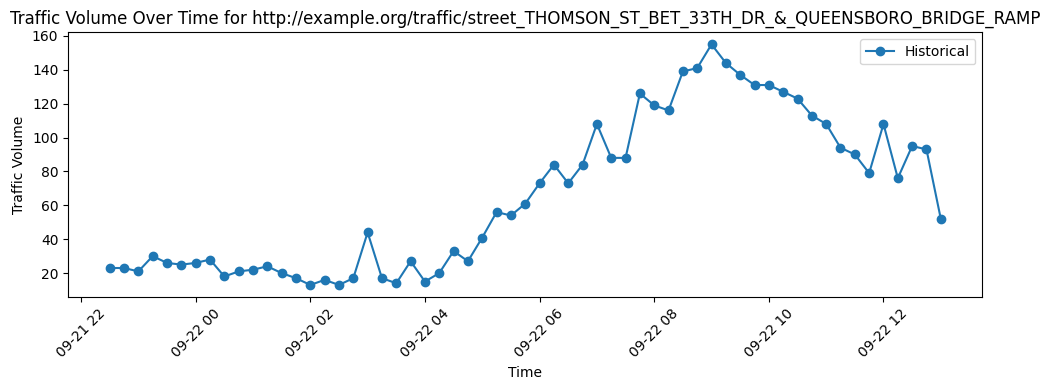

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=465.655, Time=1.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=473.273, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=470.371, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=469.828, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=471.349, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=466.648, Time=0.40 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=466.743, Time=0.12 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=462.653, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=460.685, Time=0.12 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=460.823, Time=0.12 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=462.645, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=468.862, Time=0.08 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=461.142, Time=0.13 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=464.635, Time=0.36 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=458.7

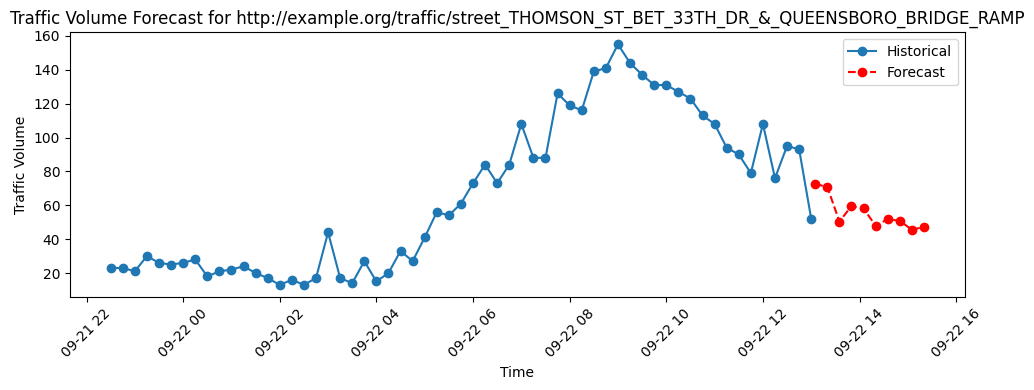

In [4]:
import warnings
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

# Filter out street nodes based on their type attribute
street_nodes = [node for node, data in G.nodes(data=True) if data.get("type") == street_type_iri]
print(f"Total street nodes in graph: {len(street_nodes)}")

# Build an index mapping each street node to its observation nodes
print("Building observedAt index...")
observed_index = build_observed_index(G)
print(f"Index built for {len(observed_index)} streets with observations.")

# Select a particular street
if len(street_nodes) == 0:
    raise ValueError("No street nodes found.")
selected_street = "http://example.org/traffic/street_THOMSON_ST_BET_33TH_DR_&_QUEENSBORO_BRIDGE_RAMP"
print(f"\nSelected street for forecasting: {selected_street}")

# Extract the time series dataframe for the selected street
fdf = extract_time_series_from_index(G, selected_street, observed_index)
if fdf.empty:
    raise ValueError(f"No valid observations found for street: {selected_street}")

# Set datetime as index and sort
fdf.set_index("datetime", inplace=True)
fdf.sort_index(inplace=True)

# Plot historical data
plt.figure(figsize=(10, 4))
plt.plot(fdf.index, fdf["volume"], marker="o", label="Historical")
plt.title(f"Traffic Volume Over Time for {selected_street}")
plt.xlabel("Time")
plt.ylabel("Traffic Volume")
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()


# Fine-tune ARIMA using auto_arima from pmdarima
warnings.filterwarnings("ignore")

# auto_arima will try a range of (p,d,q) values and select the best model based on AIC
auto_model = pm.auto_arima(fdf["volume"], seasonal=False, stepwise=True,
                           approximation=False, trace=True)
print(auto_model.summary())

# Use the best order found
order = auto_model.order
model = ARIMA(fdf["volume"], order=order)
model_fit = model.fit()
print(model_fit.summary())


# Forecasting future observations
forecast_steps = 10 # number of forecasted steps

forecast = model_fit.forecast(steps=forecast_steps)
print("\nForecasted volumes for the next {} time step(s):".format(forecast_steps))
print(forecast)


# If the historical data is hourly, but you want the forecast points, for example,
# every 15 minutes, adjust the timedelta and frequency accordingly.
# -------------------------------
last_date = fdf.index[-1]

# For instance, to forecast every 15 minutes:
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(minutes=5),
                               periods=forecast_steps, freq='15T')

# Plot historical data and forecast
plt.figure(figsize=(10, 4))
plt.plot(fdf.index, fdf["volume"], marker="o", label="Historical")
plt.plot(forecast_dates, forecast, marker="o", linestyle="--", color="red", label="Forecast")
plt.title(f"Traffic Volume Forecast for {selected_street}")
plt.xlabel("Time")
plt.ylabel("Traffic Volume")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# **Doing the same using spatiotemporal GNNs**

# **First we try STGCN**

# **Ensuring we have the latest versions since many packages now provide pre-built wheels.**

In [22]:
!pip install --upgrade pip setuptools

  Using cached setuptools-76.0.0-py3-none-any.whl.metadata (6.7 kB)
Using cached setuptools-76.0.0-py3-none-any.whl (1.2 MB)
  Attempting uninstall: setuptools
    Found existing installation: setuptools 75.1.0
    Uninstalling setuptools-75.1.0:
      Successfully uninstalled setuptools-75.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


In [5]:
!pip install torch-geometric-temporal

  Using cached torch_geometric_temporal-0.54.0-py3-none-any.whl
  Using cached pandas-1.3.5.tar.gz (4.7 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch_geometric_temporal.nn.recurrent import STGCN as STGCNLayer

if 'value' not in fdf.columns:
    # If the column is not named, we take the first column as the observation.
    fdf['value'] = fdf.iloc[:, 0]

# Convert the DataFrame to a tensor.
# We assume a univariate time series for a single street, so num_nodes=1 and num_features=1.
data_series = torch.tensor(fdf['value'].values, dtype=torch.float)
# Reshape to [time_steps, num_nodes, num_features] i.e. [T, 1, 1]
data_series = data_series.unsqueeze(1).unsqueeze(-1)
print("Data series shape:", data_series.shape)


# Create a Trivial Graph for a Single Node
# We create a graph with one node (node 0)
# and add a self-loop so that the STGCN layer can operate.
edge_index = torch.tensor([[0], [0]], dtype=torch.long)
print("Edge index:", edge_index)


# Define the STGCN Model

class STGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(STGCN, self).__init__()
        self.stgcn1 = STGCNLayer(in_channels, hidden_channels, K=2)
        self.relu = nn.ReLU()
        self.stgcn2 = STGCNLayer(hidden_channels, out_channels, K=2)

    def forward(self, x, edge_index):
        # x: [num_nodes, in_channels]
        x = self.stgcn1(x, edge_index)
        x = self.relu(x)
        x = self.stgcn2(x, edge_index)
        return x

# Create the model. Here in_channels=1 (observation per time step),
# hidden_channels is set to 16, and out_channels=1 (forecast value)
model = STGCN(in_channels=1, hidden_channels=16, out_channels=1)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Train the Model for One-Step Forecasting

epochs = 50
model.train()
num_time_steps = data_series.shape[0]

for epoch in range(epochs):
    optimizer.zero_grad()
    loss_epoch = 0
    # Using a sliding-window approach: predict time t+1 from time t
    for t in range(num_time_steps - 1):
        x = data_series[t]         # shape: [1, 1]
        target = data_series[t+1]    # shape: [1, 1]
        output = model(x, edge_index)  # output shape: [1, 1]
        loss = criterion(output, target)
        loss_epoch += loss
    loss_epoch.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss_epoch.item()}")


# Forecast the Next Time Step

model.eval()
with torch.no_grad():
    last_obs = data_series[-1]  # last observed time step: shape [1, 1]
    forecast = model(last_obs, edge_index)
    print("Forecast for next time step:", forecast.item())

ModuleNotFoundError: No module named 'torch_geometric.utils.to_dense_adj'